# Interface
##### LCEL은 Runnable을 체인으로 구성하는 선언적 방법이다.
##### Runnable은 맞춤형 체인을 최대한 쉽게 생성할 수 있도록 만든 프로토콜입니다.
##### Runnable 프로토콜은 대부분의 구성 요소로 구현되는데 이런 것들이 사용자 정의 체인을 쉽게 정의하고 표준 방식으로 호출할 수 있는 표준 인터페이스이다.
##### 표준 인터페이스에는 다음이 포함된다.


*   stream : 응답의 청크를 다시 스트리밍
*   invoke : 입력에서 체인을 호출
*   batch : 입력 목록에서 체인을 호출

##### 여기에 해당하는 비동기 메서드도 있다.



*   astream : 비동기 응답 청크를 다시 스트리밍
*   ainvoke : 입력 비동기에서 체인을 호출
*   abatch : 입력 목록에서 체인을 비동기식으로 호출
*   astream_log : 최종 응답 외에도 중간 단계가 발생하면 다시 스트리밍
*   astream_events : 체인에서 발생하는 베타 스트림 이벤트

##### 입력 유형과 출력 유형은 구성요소에 따라 다르다.

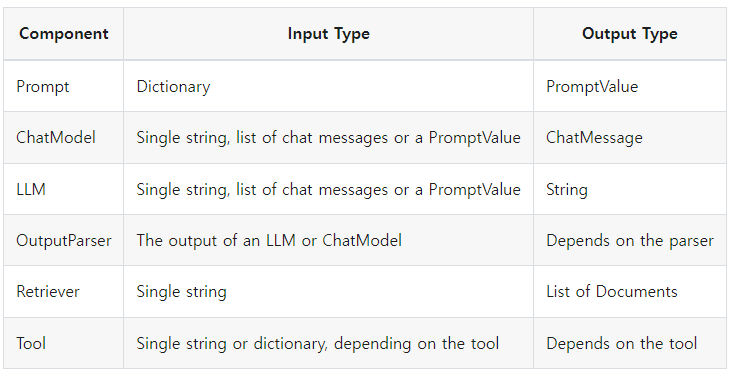





##### 모든 실행 가능 항목은 입력 및 출력을 검사하기 위해 입력 및 출력 스키마를 노출한다.
##### input_schema : Runnable 구조에서 자동 생성된 입력 Pydantic 모델
##### output_schema : Runnable 구조에서 자동 생성된 출력 Pydantic 모델

##### 위에서 표시한 입력/출력/stream/invoke/batch/비동기 .. 를 예를 들어서 이해하자

In [ ]:
!pip install --upgrade --quiet langchain-core langchain-community langchain-openai

In [ ]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.2 MB/s eta 0:00:00


In [ ]:
import os
os.environ['OPENAI_API_KEY'] = "EXAMPLE"

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

model = ChatOpenAI()
prompt = ChatPromptTemplate.from_template("tell me a joke about {topic}")
chain = prompt | model

## Input Schema
##### Runnable이 허용하는 입력에 대한 설명이다.
##### 동적으로 생성된 Pydantic 모델이고, .schema()를 호출하여 JSONSchema 표현을 얻을 수 있다.

In [ ]:
chain.input_schema.schema()

{'title': 'PromptInput',
 'type': 'object',
 'properties': {'topic': {'title': 'Topic', 'type': 'string'}}}

In [ ]:
prompt.input_schema.schema()

{'title': 'PromptInput',
 'type': 'object',
 'properties': {'topic': {'title': 'Topic', 'type': 'string'}}}

In [ ]:
model.input_schema.schema()

## 출력
##### Runnable이 생성한 출력에 대한 설명이다.
##### 동적으로 생성된 Pydantic 모델이고, .schema()를 호출하여 JSONSchema 표현을 얻을 수 있다.

In [ ]:
chain.output_schema.schema()

## stream

In [ ]:
for s in chain.stream({"topic": "bears"}):
  # print(s.content, end="", flush=True)
  print(s)

content=''
content='Why'
content=' did'
content=' the'
content=' bear'
content=' break'
content=' up'
content=' with'
content=' his'
content=' girlfriend'
content='?\n'
content='Because'
content=' she'
content=' was'
content=' unbearable'
content='!'
content='' response_metadata={'finish_reason': 'stop'}


## invoke

In [ ]:
chain.invoke({"topic":"bears"})

AIMessage(content='Why did the bear sit on the stove?\n\nBecause he wanted to be a hot cross bear!', response_metadata={'finish_reason': 'stop', 'logprobs': None})

## batch

In [ ]:
chain.batch([{"topic": "bears"}, {"topic":"cats"}])

[AIMessage(content="Why did the bear break up with his girlfriend? \n\nBecause he couldn't bear the relationship any longer!", response_metadata={'finish_reason': 'stop', 'logprobs': None}),
 AIMessage(content='Why was the cat sitting on the computer? \nBecause it wanted to keep an eye on the mouse!', response_metadata={'finish_reason': 'stop', 'logprobs': None})]

##### max_concurrecy 매개변수를 사용하여 동시 요청 수를 설정할 수 있다.

In [ ]:
chain.batch([{"topic": "bears"}, {"topic":"cats"}], config={"max_conurrecy": 5})

[AIMessage(content="Why did the bear break up with his girlfriend? \n\nBecause he couldn't bear the relationship any longer!", response_metadata={'finish_reason': 'stop', 'logprobs': None}),
 AIMessage(content='Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!', response_metadata={'finish_reason': 'stop', 'logprobs': None})]

## astream, ainvoke, abatch

In [ ]:
async for s in chain.astream({"topic": "bears"}):
  print(s.content, end="", flush=True)

Why do bears have hairy coats?

Fur protection!

In [ ]:
await chain.ainvoke({"topic": "bears"})

AIMessage(content="Why did the bear break up with his girlfriend? \n\nBecause he couldn't bear the relationship anymore!", response_metadata={'finish_reason': 'stop', 'logprobs': None})

In [ ]:
await chain.abatch([{"topic": "bears"}])

[AIMessage(content="Why did the bear break up with his girlfriend?\n\nBecause he couldn't bear the relationship any longer!", response_metadata={'finish_reason': 'stop', 'logprobs': None})]

## 비동기 스트림 이벤트 (베타)
##### 이벤트 스트리밍은 베타 API이며, langchain-core 0.2.0에서 도입됨.
##### astream_events_API를 사용할 때 아래 사항을 수행해야 한다.



*   async를 코드 전체에서 사용
*   사용자 정의 함수/실행 파일을 정의하는 경우 콜백을 전파한다.
*   LCEL 없이 실행 가능 파일을 사용할 때마다 LLM이 토큰을 스트리밍(.astream)하도록 강제하기 보다는 LLM을 호출(.invoke)해라.




### 이벤트
##### 다양한 Runnable 객체에서 발생할 수 있는 이벤트를 보여주는 참조 테이블 링크를 첨부한다.
https://python.langchain.com/docs/expression_language/interface#async-stream-events-beta
##### 참고로 스트리밍할 때 입력 스트림이 완전히 소비될 때까지 실행 가능 항목에 대한 입력을 사용할 수 없다!
##### 대표적으로 몇 가지 이벤트와 관련된 선언을 보자.(format_docs, some_tool, prompt)

##### format_docs
```python
def format_docs(docs: List[Document]) -> str:
    '''Format the docs.'''
    return ", ".join([doc.page_content for doc in docs])

format_docs = RunnableLambda(format_docs)
```

##### some_tool
```python
@tool
def some_tool(x: int, y: str) -> dict:
    '''Some_tool.'''
    return {"x": x, "y": y}
```

##### prompt
```python
template = ChatPromptTemplate.from_messages(
    [("system", "You are Cat Agent 007"), ("human", "{question}")]
).with_config({"run_name": "my_template", "tags": ["my_template"]})
```

##### astream_events를 적용하기 위해 새로운 체인을 생성하자

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

vectorstore = FAISS.from_texts(
    ["harrison worked at kensho"], embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

retrieval_chain = (
    {
        "context": retriever.with_config(run_name="Docs"),
        "question": RunnablePassthrough(),
    }
    | prompt
    | model.with_config(run_name="my_llm")
    | StrOutputParser()
)

##### 이제 검색기와 LLM에서 이벤트를 가져오는것을 사용해보자(astream_events)

In [ ]:
# 이벤트의 종류에 따라 다른 출력을 주어 어떤 이벤트가 실행되었는지 알아본다.
async for event in retrieval_chain.astream_events(
    "where did harrison work?", version="v1", include_names=["Docs", "my_llm"]
):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="|")
    elif kind in {"on_chat_model_start"}:
        print()
        print("Streaming LLM:")
    elif kind in {"on_chat_model_end"}:
        print()
        print("Done streaming LLM.")
    elif kind == "on_retriever_end":
        print("--")
        print("Retrieved the following documents:")
        print(event["data"]["output"]["documents"])
    elif kind == "on_tool_end":
        print(f"Ended tool: {event['name']}")
    else:
        pass

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/beta_decorator.py:86: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


--
Retrieved the following documents:
[Document(page_content='harrison worked at kensho')]

Streaming LLM:
|H|arrison| worked| at| Kens|ho|.||
Done streaming LLM.


## 비동기 스트림 중간
##### .astream_log()는 모든 실행 가능 항목에서 체인/시퀀스 중간 단계 전체 또는 일부를 스트리밍하는 메서드이다.
##### 사용자에게 진행 사항을 표시하거나, 중간 결과를 사용하거나, 체인을 디버깅하는데 유용하다.
##### 모든 단계를 스트리밍하거나, 이름, 태그 또는 메타데이터별로 단계를 포함/제외할 수 있다.

```python
class LogEntry(TypedDict):
    id: str
    """ID of the sub-run."""
    name: str
    """Name of the object being run."""
    type: str
    """Type of the object being run, eg. prompt, chain, llm, etc."""
    tags: List[str]
    """List of tags for the run."""
    metadata: Dict[str, Any]
    """Key-value pairs of metadata for the run."""
    start_time: str
    """ISO-8601 timestamp of when the run started."""

    streamed_output_str: List[str]
    """List of LLM tokens streamed by this run, if applicable."""
    final_output: Optional[Any]
    """Final output of this run.
    Only available after the run has finished successfully."""
    end_time: Optional[str]
    """ISO-8601 timestamp of when the run ended.
    Only available after the run has finished."""


class RunState(TypedDict):
    id: str
    """ID of the run."""
    streamed_output: List[Any]
    """List of output chunks streamed by Runnable.stream()"""
    final_output: Optional[Any]
    """Final output of the run, usually the result of aggregating (`+`) streamed_output.
    Only available after the run has finished successfully."""

    logs: Dict[str, LogEntry]
    """Map of run names to sub-runs. If filters were supplied, this list will
    contain only the runs that matched the filters."""
```

In [ ]:
async for chunk in retrieval_chain.astream_log(
    "where did harrison work?", include_names=["Docs"]
):
    print("-" * 40)
    print(chunk)

##### 더 자세한 값을 얻고 싶다면 diff 파라미터를 False로 둔다.

In [ ]:
async for chunk in retrieval_chain.astream_log(
    "where did harrison work?", include_names=["Docs"], diff=False
):
    print("-" * 70)
    print(chunk)

## 병렬성
##### LCEL은 병렬성을 지원한다. RunnableParallel를 사용하면 각 요소가 병렬로 실행된다.

In [ ]:
from langchain_core.runnables import RunnableParallel

chain1 = ChatPromptTemplate.from_template("{주제}에 대한 농담 말해줘") | model
chain2 = (
    ChatPromptTemplate.from_template("{주제}에 대해 2줄 정도의 시를 써줘") | model
)
combined = RunnableParallel(joke=chain1, poem=chain2)

In [ ]:
%%time
chain1.invoke({"주제": "강아지"})

CPU times: user 43.8 ms, sys: 4.26 ms, total: 48.1 ms
Wall time: 1.38 s


AIMessage(content='왜 강아지가 컴퓨터를 못 쓰냐면? \n\n키보드가 너무 뻣뻣해서 손가락이 미끄러워서!', response_metadata={'finish_reason': 'stop', 'logprobs': None})

In [ ]:
%%time
chain2.invoke({"주제": "강아지"})

CPU times: user 38.9 ms, sys: 3.98 ms, total: 42.9 ms
Wall time: 1.42 s


AIMessage(content='꼬리를 흔들며 즐거운 모습으로\n사랑스러운 강아지 나의 친구여 영원히 함께하리.', response_metadata={'finish_reason': 'stop', 'logprobs': None})

In [ ]:
%%time
combined.invoke({"주제": "강아지"})

CPU times: user 60.1 ms, sys: 4.02 ms, total: 64.1 ms
Wall time: 1.36 s


{'joke': AIMessage(content='왜 강아지가 항상 화가 나있나요? \n\n푹신한 모래밭을 걸어다니면서도 계속 짖기 때문이에요!', response_metadata={'finish_reason': 'stop', 'logprobs': None}),
 'poem': AIMessage(content='꼬리를 흔들며 즐거운 모습으로\n사랑스러운 강아지, 나의 작은 친구여.', response_metadata={'finish_reason': 'stop', 'logprobs': None})}

### 배치의 병렬성
##### 병렬성은 다른 실행 가능 항목과 결합 가능하다.

In [ ]:
%%time
chain1.batch([{"주제":"곰"},{"주제":"고양이"}])

CPU times: user 59.4 ms, sys: 16.8 ms, total: 76.2 ms
Wall time: 1.6 s


[AIMessage(content='곰이 왜 항상 화를 내냐면, 진정한 곰은 항상 웃는 것도 잘하거든.', response_metadata={'finish_reason': 'stop', 'logprobs': None}),
 AIMessage(content='고양이가 무엇을 읽을 때 가장 행복해할까요?\n"미아웃"이라는 책을 읽을 때요!', response_metadata={'finish_reason': 'stop', 'logprobs': None})]

In [ ]:
%%time
chain2.batch([{"주제":"곰"},{"주제":"고양이"}])

CPU times: user 60.4 ms, sys: 1.99 ms, total: 62.4 ms
Wall time: 1.48 s


[AIMessage(content='숲 속 깊은 곳에서\n곰이 꿈틀거리는 소리가 들려온다.', response_metadata={'finish_reason': 'stop', 'logprobs': None}),
 AIMessage(content='부드럽고 귀여운 고양이야,\n나의 마음을 편안하게 만들어주는 친구야.', response_metadata={'finish_reason': 'stop', 'logprobs': None})]

In [ ]:
%%time
combined.batch([{"주제":"곰"},{"주제":"고양이"}])

CPU times: user 153 ms, sys: 13.2 ms, total: 167 ms
Wall time: 2.47 s


[{'joke': AIMessage(content='곰이 왜 음주운전을 하지 않는가?\n\n- "취하면 허락하고, 취하지 않으면 허락하지 않는다."', response_metadata={'finish_reason': 'stop', 'logprobs': None}),
  'poem': AIMessage(content='숲 속 깊이 숨은 곰의 눈은\n우리를 위협하지 않고 순수한 모습으로 빛나네.', response_metadata={'finish_reason': 'stop', 'logprobs': None})},
 {'joke': AIMessage(content="고양이가 왜 항상 귀엽게 보일까?\n그들은 '미야옹'을 하면서 눈을 반짝이기 때문이야!", response_metadata={'finish_reason': 'stop', 'logprobs': None}),
  'poem': AIMessage(content='부드러운 털과 귀여운 모습\n고양이는 마음을 따뜻하게 만들어 준다.', response_metadata={'finish_reason': 'stop', 'logprobs': None})}]